# Customer Purchase Classification

Build a decision tree classifier to determine whether a customer is likely to purchase a product based on their information and demographic data.

## Data Understanding



The data is related with direct marketing campaigns of a Portuguese banking institution. 

The marketing campaigns were based on phone calls. 

Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

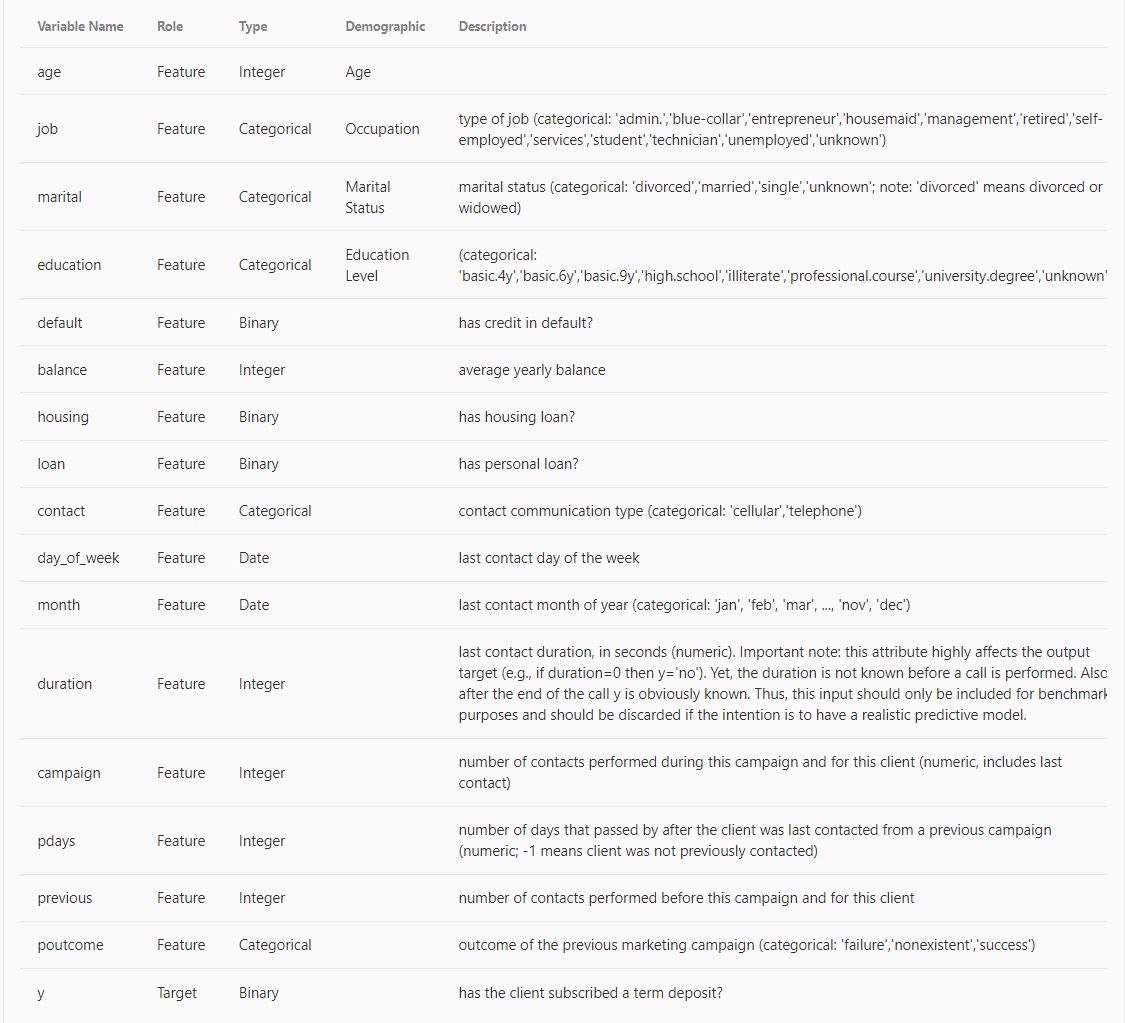

From the [data scource](https://archive.ics.uci.edu/dataset/222/bank+marketing), contact, pdays and poutcome have missing values.

In [93]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Setting optional parameters
%matplotlib inline
warnings.simplefilter(action='ignore', category=('FutureWarning'))
plt.style.use('ggplot')

In [52]:
# Importing data
data = pd.read_csv('../PRODIGY_DS_03/Data/bank/bank-full.csv', sep=';')

In [53]:
# View the data
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [54]:
# Basic data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [55]:
display(data.describe(include='object'))  # Object columns descriptions
display(data.describe(include=['int', 'float']))  # NUmeric columns descriptions

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Poutcome is likely to have an issue as the 'unknown' class is the mode with a frequency of 36959 against the total records of 45211. 

Next we are going to check for the presence of duplicates then look at contact, pdays and poutcome which were said to have missing values in the data description.

In [56]:
# Check for duplicates
# The columns selected for the subset are selected as they best represent the demographic of the customer
# E.g customers can't have same age, job, marital status and bank balance  
data.duplicated(subset=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'y']).sum() / data.shape[0]

0.05708787684413085

There are 5% duplicate values based on customer demographic. These duplicates will be dropped from the dataset.

In [57]:
data.drop_duplicates(subset=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'y'], inplace=True, ignore_index=True)

print(data.shape)

(42630, 17)


In [58]:
# Subsetting the columns
missing_v = data[['contact', 'pdays', 'poutcome']]

for col in missing_v.columns:
    display(missing_v[col].value_counts())

contact
cellular     26999
unknown      12845
telephone     2786
Name: count, dtype: int64

pdays
-1      36127
 182      125
 370       97
 183       92
 181       81
        ...  
 633        1
 670        1
 551        1
 686        1
 530        1
Name: count, Length: 543, dtype: int64

poutcome
unknown    36132
failure     3786
other       1769
success      943
Name: count, dtype: int64

There is a high number of 'unknown' values in the columns above.

    Since there are ~36000 records that are of unknown outcome from the last campain and also about the same number of customers that were not previously contacted, what is the number of customers that haven't been contacted at all (previous = 0)?

In [59]:
# Subsetting customers that have never been contacted before
not_contacted = data[data['previous'] == 0].copy()

In [60]:
# Checking the description of customers never contacted
display(not_contacted.describe(include='object'))
display(not_contacted.describe())

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,36127,36127,36127,36127,36127,36127,36127,36127,36127,36127
unique,12,3,4,2,2,2,3,12,1,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,7949,21902,18566,35372,19639,30039,21083,11084,36127,32752


,age,balance,day,duration,campaign,pdays,previous
count,36127.000000,36127.000000,36127.000000,36127.000000,36127.000000,36127.0,36127.0
mean,40.973565,1348.278379,16.100977,258.536635,2.910095,-1.0,0.0
std,10.465273,3067.701246,8.365220,262.830708,3.310435,0.0,0.0
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.0,0.0
25%,33.000000,72.000000,8.000000,101.000000,1.000000,-1.0,0.0
50%,39.000000,436.000000,16.000000,178.000000,2.000000,-1.0,0.0
75%,49.000000,1394.500000,22.000000,318.000000,3.000000,-1.0,0.0
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,-1.0,0.0


For customers who have never had any contact with the bank, their time since last contact is -1 (Never contacted), outcome from previous contact is unknown `only 5 unknown poutcome(s) have had previous contact`. Nothing stands out in those 5 records. 

A decision tree classifier is very sensitive to outliers, therefore, we will check for the presence of outliers in the numeric data by use of boxplots.

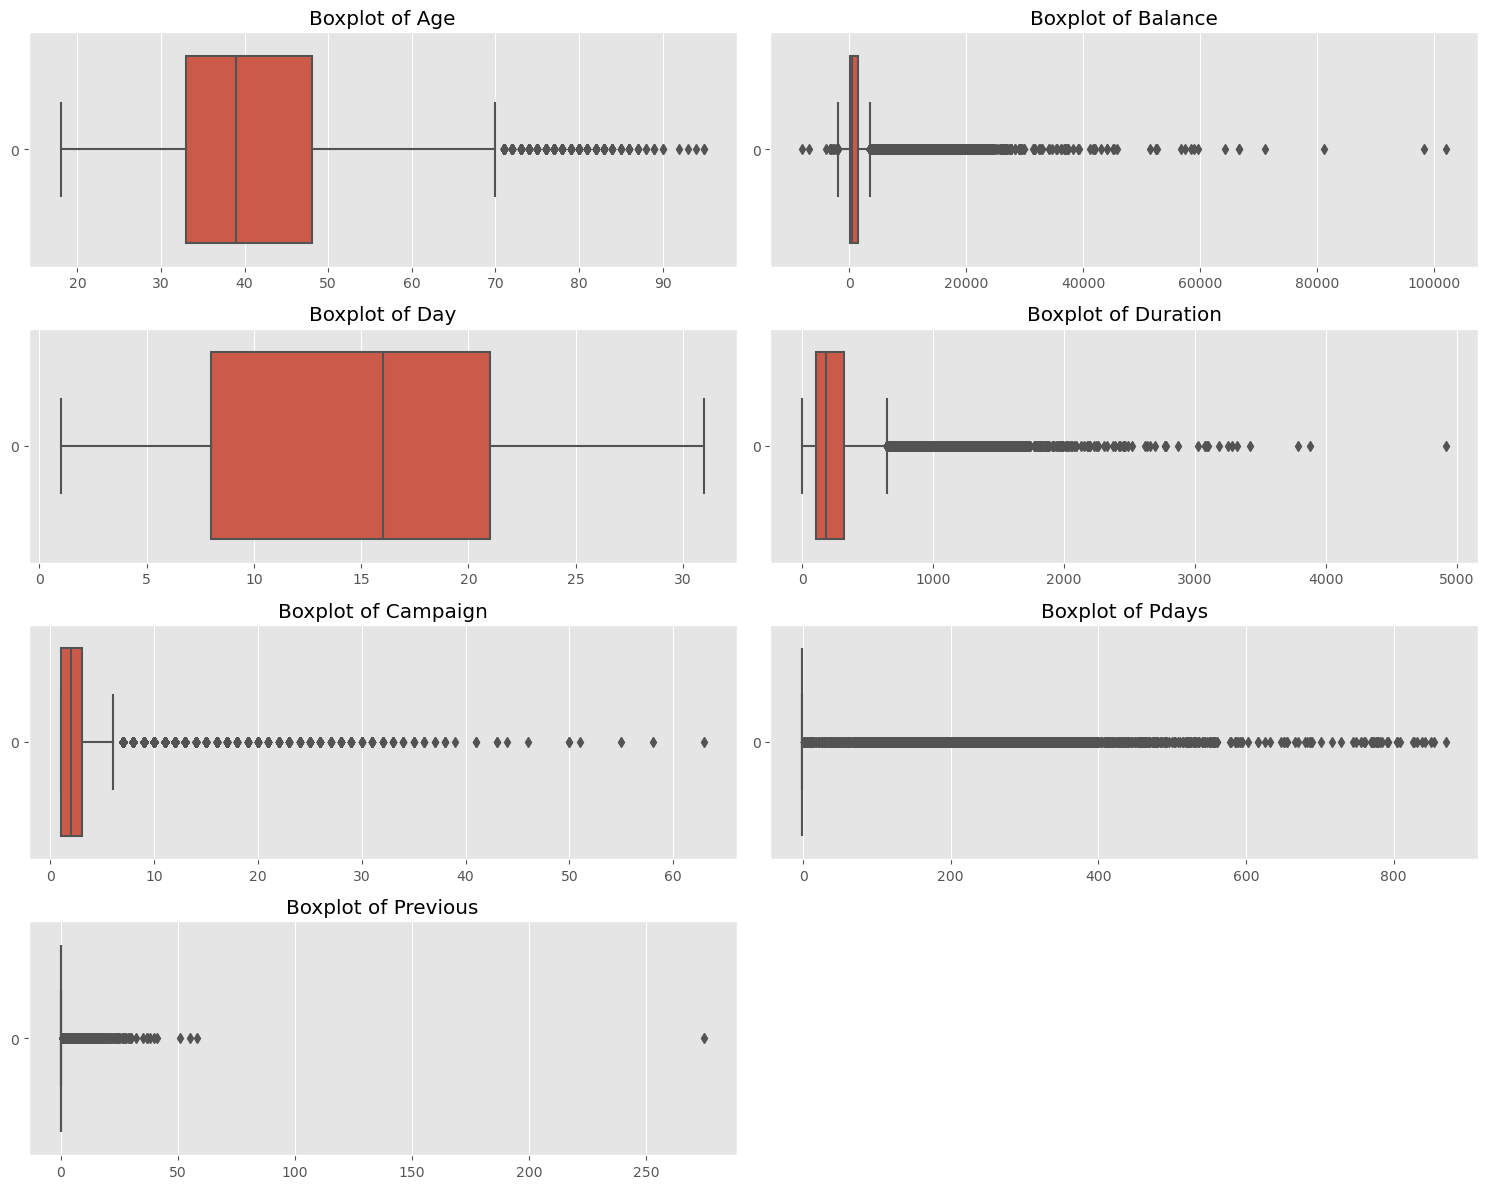

In [61]:
# Subsetting numeric columns
numeric_df = data.select_dtypes(include=['float', 'int'])

# Boxplots for numeric data
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
ax = ax.flatten()
numeric_col_iter = iter(numeric_df.columns.to_list())

for axis in list(ax):
    try:
        column_name = next(numeric_col_iter)
        sns.boxplot(data=numeric_df[column_name], ax=axis, orient='h')
        axis.set_title(f"Boxplot of {column_name.title()}")

    except StopIteration:
        axis.remove()

plt.tight_layout()


Values likely to be outliers: (Thresholds may be revised after building the model)
- Balance above 60000 
- Duration above 4000
- Previous above 100

In [69]:
# Subsetting possible outliers
display(data[data['balance'] > 60000])  # Balance outliers

display(data[data['duration'] > 3500])  # Duration outliers

display(data[data['previous'] > 100])  # Previous outliers

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
19162,59,admin.,married,unknown,no,64343,no,no,cellular,6,aug,45,4,-1,0,unknown,no
19521,56,management,divorced,tertiary,no,66721,no,no,cellular,8,aug,442,2,-1,0,unknown,no
20899,52,blue-collar,married,primary,no,66653,no,no,cellular,14,aug,109,3,-1,0,unknown,no
25526,59,management,married,tertiary,no,98417,no,no,telephone,20,nov,145,5,-1,0,unknown,no
38369,51,management,single,tertiary,no,102127,no,no,cellular,3,jun,90,1,-1,0,unknown,no
39817,60,retired,married,primary,no,71188,no,no,cellular,6,oct,205,1,-1,0,unknown,no
40533,84,retired,married,secondary,no,81204,no,no,telephone,28,dec,679,1,313,2,other,yes


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
9830,59,management,married,secondary,no,1321,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
23606,59,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,4918,1,-1,0,unknown,no
42142,45,services,single,secondary,no,955,no,no,unknown,27,aug,3785,1,-1,0,unknown,no


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
28303,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no


In [70]:
# Dropping the outliers
data = data[~((data['balance'] > 60000) | (data['duration'] > 3500) | (data['previous'] > 100))].copy()

<Axes: xlabel='y'>

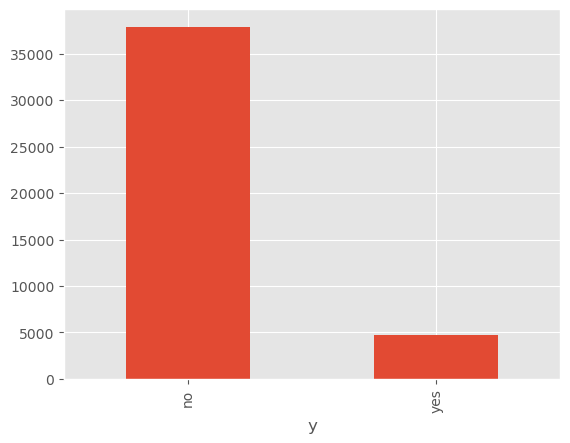

In [75]:
# Distribution of the target variable
data['y'].value_counts().plot.bar()

Note: There is a massive class imbalance in the target variable. This would be problematic when building the model as the imbalance introduces some classification bias.

## Preprocessing

### Train-Test splitting

In [77]:
# Separating X and y data
X = data.drop('y', axis=1)
y = data['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # Stratify since the data is highly imbalanced

### Label Encoding


## Data Modelling

In [92]:
# Baseline model (No scaling and resampling)
baseline_model = DecisionTreeClassifier(random_state=42)

baseline_model.fit(X_train, y_test)
base_train_preds = baseline_model.predict_proba(X_train)
base_test_preds = baseline_model.predict_proba(X_test)
base_train_logloss = log_loss(y_train, base_train_preds)
base_test_logloss = log_loss(y_test, base_test_preds)

print(base_train_logloss, base_test_logloss)


ValueError: could not convert string to float: 'self-employed'

In [ ]:
Check duplicates, outliers and data types.

Descriptions & Distributions of the columns

Distribution of target variable.

